In [16]:
# python3
import gzip
import pandas as pd
import numpy as np
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import re
from time import time
import pickle
import operator

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/manjukiran/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/manjukiran/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Loading Data

In [4]:
with gzip.open('Beeradvocate.txt.gz', 'r') as f:
    rb_file = f.readlines()

data = []
row_out = []
stop = stopwords.words('english')

for i in rb_file:
    row = i.decode('utf-8', errors = 'replace')
    #print(row)
    if row == '\n':
        data.append(row_out)
        row_out = []
        continue
    cat, field = row.split(":", 1)
    #remove leading white spaces
    field = field.rstrip()
    if cat == 'review/text':
        #remove tab and newspace characters
        field = field.replace('\t', ' ')
        field = field.replace('\n', '')
        
        #remove punctuation and spaces
        field = re.sub(r'[^\w\s]','',field) #slower but effective
        field = field.lower()
    row_out.append(field)

In [5]:
data = pd.DataFrame(data)

data.columns = ['beer_name', 'beer_beerId', 'beer_brewer', 'beer_ABV', 'beer_style', 
                'review_appearance', 'review_aroma', 'review_palate', 'review_taste', 
                'review_overall', 'review_time', 'review_profileName', 'review_text']


corpus = data[['beer_beerId', 'review_text']].groupby('beer_beerId').agg(' '.join)
#sample = corpus.iloc[0:1000]

In [31]:
data.iloc[100].beer_name

' Caldera Pale Ale'

# TF-IDF

### Calculating TF-IDF scores for entire corpus

In [17]:
import sklearn
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

stemmer = SnowballStemmer("english")
n_features = 500

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

t0 = time()

tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize, stop_words='english', max_features = n_features)
tfidf = tfidf_vectorizer.fit_transform(corpus['review_text'])
print("done in %0.3fs." % (time() - t0))

/Users/manjukiran/opt/anaconda3/envs/Beer_RS/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  % sorted(inconsistent)


done in 2591.343s.


In [18]:
# save the model to disk
filename1 = 'tfidf.sav'
filename2 = 'tfidf_vec.sav'
pickle.dump(tfidf, open(filename1, 'wb'))
pickle.dump(tfidf_vectorizer, open(filename2, 'wb'))

### Load TF-IDF scores for entire corpus

In [19]:
filename1 = 'tfidf.sav'
filename2 = 'tfidf_vec.sav'
tfidf = pickle.load(open(filename1, 'rb'))
tfidf_vectorizer = pickle.load(open(filename2, 'rb'))

In [20]:
tfidf_map = {}

for i in range(len(corpus.index.values)):
    beer_id = corpus.index.values[i]
    tfidf_representation = tfidf[i]
    tfidf_map[beer_id] = tfidf_representation


In [22]:
test = corpus.iloc[1001]['review_text']
response = tfidf_vectorizer.transform([test])

feature_names = tfidf_vectorizer.get_feature_names()
for col in response.nonzero()[1]:
    print(feature_names[col], ' - ', response[0, col])

worth  -  0.1322894358716235
weak  -  0.15408824137363328
version  -  0.15267880856286864
veri  -  0.21533191716268155
tri  -  0.21274334844530224
tast  -  0.06784329699639786
sweet  -  0.07559599248844218
surpris  -  0.12853119026837537
summer  -  0.15967856051144233
slight  -  0.172694031845161
refresh  -  0.1296548226523986
quick  -  0.11369780493938554
price  -  0.1747155678971983
pour  -  0.07488613697904137
pack  -  0.16958996558257994
ok  -  0.14514660186686898
noth  -  0.12146436021101041
mouthfeel  -  0.16613474636075667
light  -  0.1502260659412969
label  -  0.14513834691205257
ive  -  0.12314270490279926
hue  -  0.13571979794563915
hot  -  0.1589460260353605
hint  -  0.09575923764783031
head  -  0.06098626751225169
got  -  0.12952642889140592
gold  -  0.13605950513645493
finish  -  0.07940279126693095
fine  -  0.13314014370848454
fantast  -  0.17369903148072938
fade  -  0.259184309964984
especi  -  0.15153911627107347
drinkabl  -  0.1798230044061108
clear  -  0.1025733296343

/Users/manjukiran/opt/anaconda3/envs/Beer_RS/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Training a linear model for each user

### Models for all users with >= 10 reviews

In [28]:
#Find beers consumed by each user
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

min_reviews = 10

t0 = time()

#users = data['review_profileName'].unique()
n_by_user = data['review_profileName'].value_counts()
users = n_by_user[n_by_user > min_reviews].index.values

user_reg= {}

for u in users:
    reviews = data[data['review_profileName'] == u]
    y = reviews['review_overall']
    
    if len(reviews) < 10:
        continue
    
    X = []
    for beer_id in reviews['beer_beerId']:
        X.append(tfidf_map[beer_id])
    
    X = np.vstack(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    print(X_train, y_train)
    
    reg = LinearRegression().fit(X_train, y_train)
    
    #calculate RMSE
    RMSE = np.sqrt(np.mean((y_test.values.astype(float) - reg.predict(X_test)[0])**2))
    
    user_reg[u] = {'model': reg, 'rmse': RMSE}
    
print("done in %0.3fs." % (time() - t0))

[<1x500 sparse matrix of type '<class 'numpy.float64'>'
	with 379 stored elements in Compressed Sparse Row format>, <1x500 sparse matrix of type '<class 'numpy.float64'>'
	with 479 stored elements in Compressed Sparse Row format>, <1x500 sparse matrix of type '<class 'numpy.float64'>'
	with 339 stored elements in Compressed Sparse Row format>, <1x500 sparse matrix of type '<class 'numpy.float64'>'
	with 200 stored elements in Compressed Sparse Row format>, <1x500 sparse matrix of type '<class 'numpy.float64'>'
	with 282 stored elements in Compressed Sparse Row format>, <1x500 sparse matrix of type '<class 'numpy.float64'>'
	with 127 stored elements in Compressed Sparse Row format>, <1x500 sparse matrix of type '<class 'numpy.float64'>'
	with 101 stored elements in Compressed Sparse Row format>, <1x500 sparse matrix of type '<class 'numpy.float64'>'
	with 314 stored elements in Compressed Sparse Row format>, <1x500 sparse matrix of type '<class 'numpy.float64'>'
	with 202 stored element

ValueError: setting an array element with a sequence.

In [78]:
filename3 = 'user_reg.sav'
pickle.dump(user_reg, open(filename3, 'wb'))

# Model Evaluation

Load linear models from local file

In [5]:
user_reg = pickle.load(open('user_reg.sav', 'rb'))

Average RMSE by user

In [6]:
#average RMSE by user
np.mean([value['rmse'] for index, value in user_reg.iteritems()])

0.95578283614248305

In [8]:
#number of reviews by user
n_by_users = data['review_profileName'].value_counts()
#only users with > 10 reviews
n_by_users = pd.DataFrame(n_by_users[n_by_users > 10])
n_by_users = n_by_users.rename(columns = {'review_profileName': 'n_reviews'})

#add the RMSE for each user
rmse = []

for user in n_by_users.index.values:
    rmse.append(user_reg[user]['rmse'])
    
n_by_users['rmse'] = rmse

Grouping users by number of reviews

In [9]:
#group users in bins by number of reviews
bins = [10, 20, 30, 40, 50, 100, 200, 500, 1000, 2000, 6000]
labels = ['11-20', '21-30', '31-40', '41-50', '51-100', '101-200', '201-500', '501-1000', '1001-2000', '2001-6000']
n_by_users['review_group'] = pd.cut(n_by_users['n_reviews'], bins = bins, labels = labels)


#find the number of users by bin
n_by_users[['rmse', 'review_group']].groupby('review_group').count().rename(columns = {'rmse': 'n_users'})


,n_users
review_group,
11-20,2665
21-30,1375
31-40,868
41-50,550
51-100,1604
101-200,1264
201-500,1158
501-1000,454
1001-2000,202


In [11]:
#find the mean rmse by bin
n_by_users[['rmse', 'review_group']].groupby('review_group').mean()

,rmse
review_group,
11-20,0.857098
21-30,0.856729
31-40,0.835981
41-50,0.880876
51-100,0.893078
101-200,0.949864
201-500,1.077986
501-1000,2.135085
1001-2000,1.108471


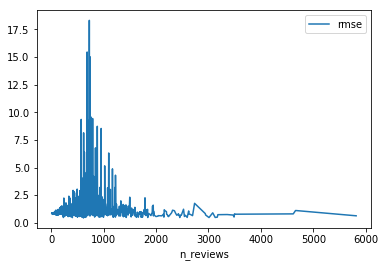

In [30]:
#plot mean RMSE by user count (WITHOUT bins)
rmse_by_reviewcount = n_by_users.groupby('n_reviews').mean()
rmse_by_reviewcount.plot.line()

In [14]:
#plot mean RMSE by user count (with bins)
rmse_by_reviewgroup = n_by_users[['rmse', 'review_group']].groupby('review_group').mean()

rmse_by_reviewgroup
#rmse_by_reviewgroup.plot.line()

,rmse
review_group,
11-20,0.857098
21-30,0.856729
31-40,0.835981
41-50,0.880876
51-100,0.893078
101-200,0.949864
201-500,1.077986
501-1000,2.135085
1001-2000,1.108471


### Building recommendations for a subset of users

In [21]:
user_subset = [ ' bronco94', 
                ' t8s8l8', 
                ' kkrez', 
                ' SERENGETI', 
                ' uabigdaz',
                ' dmbfrat420beers',
                ' Graham21',
                ' Roderick',
                ' linnet',
                ' clarkm04',
                ' nickynick',
                ' jdoncbus',
                ' cavedave',
                ' JohnnyDuvel',
                ' craytonic',
                ' Phelps',
                ' rastaman',
                ' twiggamortis420',
                ' mikesgroove',
                ' weeare138']

In [28]:
user_recs = {}

for user in user_subset:
    #get the model for that user
    model = user_reg[user]['model']
    #find predicted scores for each beer
    beer_scores = {}
    for beer_id, features in tfidf_map.iteritems():
        beer_scores[beer_id] = model.predict(features)[0]
        
    #user_beer_scores[user] = beer_scores
    user_recs[user] = [x[0] for x in sorted(beer_scores.items(), key=operator.itemgetter(1), reverse = True)[0:10]]

#pickle.dump(user_recs, open('text_recs.sav', 'wb'))

In [50]:
beer_id_map = data[['beer_name', 'beer_beerId', 'beer_style']].drop_duplicates().set_index('beer_beerId')

text_recs = {}

for user, recs in user_recs.iteritems():
    top_10 = []
    print user
    for beer_id in recs:
        beer_name = beer_id_map.loc[beer_id]['beer_name']
        beer_style = beer_id_map.loc[beer_id]['beer_style']
        top_10.append(beer_name)
        print ('\t' + beer_name+ '; ' + beer_style)
    print '\n'
    text_recs[user] = top_10


 rastaman
	 Bourbon Oaked Stout;  American Double / Imperial Stout
	 Bourbon Barrel Big Stone Stout;  American Stout
	 Barrel Aged Run For The Roses;  Irish Dry Stout
	 Ole Woody;  American IPA
	 Bourbon Barrel Aged Stout;  American Double / Imperial Stout
	 Red Racer Bourbon Barrel Aged Imperial Porter;  Baltic Porter
	 Bourbon Barrel Porter;  American Porter
	 Smoked Goose (Barrel Aged);  Belgian Pale Ale
	 Thomas Jefferson's Tavern Ale (Bourbon Barrel Aged);  American Strong Ale
	 Bourbon Barrel Aged Espresso Stout;  American Stout


 dmbfrat420beers
	 IPA;  English India Pale Ale (IPA)
	 Ahopalypse Now IPA;  American IPA
	 Old Salt IPA;  American IPA
	 Black IPA;  American IPA
	 Schlafly Centennial ESB;  Extra Special / Strong Bitter (ESB)
	 Dry Stout;  Irish Dry Stout
	 Starkers IPA;  American IPA
	 I.P.A.;  American IPA
	 Black Shag Stout;  Foreign / Export Stout
	 India Export Ale;  English India Pale Ale (IPA)


 cavedave
	 Skye Strong Ale;  American Double / Imperial IPA
	 Oat

In [52]:
pickle.dump(text_recs, open('text_recs.sav', 'wb'))